In [76]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

In [2]:
def ranking_precision_score(y_true, y_score, k=10):
    """Precision at rank k
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    Returns
    -------
    precision @k : float
    """
    unique_y = np.unique(y_true)

    if len(unique_y) == 2:
        pos_label = unique_y[1]
        n_pos = np.sum(y_true == pos_label)

        order = np.argsort(y_score)[::-1]
        y_true = np.take(y_true, order[:k])
        n_relevant = np.sum(y_true == pos_label)

        # Divide by min(n_pos, k) such that the best achievable score is always 1.0.
        return float(n_relevant) / min(n_pos, k)
    else:
        return -1
def rank_precision(data_frame,k=4): # passed to groupby object 
    y_true=list(data_frame[1])
    y_score=list(data_frame[2])
    return ranking_precision_score(y_true, y_score, k=k)

In [3]:
class Model:
    def __init__(self,name="GBDT",alpha=0,penalty=0,topk=-1,attrN=-1,preds=None,rmse=-1):
        self.name=name  # name can be GBDT or GBDTBT (GBDT with top ranking feature from BT)
        self.pen=penalty
        self.topk=topk
        self.preds=preds
        self.attrN=attrN
        self.alpha=alpha
        self.rmse=rmse
        
    def get_AUC(self):
        return roc_auc_score(trueY,self.preds) if self.preds is not None else None
    
    #add some other metrics later
    
    def get_ranking_precision(self,k=2): # ranking_precision_score averaged over queries
        combined=pd.concat([kw,trueY,self.preds],axis=1,ignore_index=True)
        grouped=combined.groupby(combined[0])
        agged=grouped.apply(rank_precision,k=k)
        agged=[num for num in agged if num>=0]
        return sum(agged)/(len(agged)) if len(agged)>0 else 0
        
        
        
        
        

In [23]:
###### result files paths

# result_path='result/us/'
# attr_total=174

# result_path='result/us_adaptive'
# attr_total=174

# result_path='result/gold_in_qa_split_new/'
# attr_total=96

result_path='result/gold_in_qa_split_adaptive/'
attr_total=96


# result_path='result/madelon/'
# attr_total=500

# result_path='result/madelon_adaptive/'
# attr_total=500



# result_path='synthetic/result_syn1_test/'
# aux_path='synthetic/aux_result_syn1_test/'
# attr_total=100



In [24]:
## preprocess

filenames_result=listdir(result_path)
trueY=pd.read_csv(result_path+"trueY.txt",header=None)[0]
try:
    kw=pd.read_csv(result_path+"keyword.txt",header=None)[0]
except:
    print("do not have groups")
try:
    number_unused=len(pd.read_csv(result_path+"preprocess_unused.txt",header=None))
except:
    number_unused=0
attr_init_number=attr_total-number_unused

In [25]:
attr_init_number

67

In [26]:
import collections

In [27]:
filenames_result

['boosting_rms_GBFS_mu0.9_alpha0.txt',
 'log_GBFS_mu0.08_alpha0.1.txt',
 'log_GBFS_mu0.8_alpha0.1.txt',
 'feature_scores_GBFS_mu0.55_alpha0.02.txt',
 'feature_scores_GBFS_mu0.01_alpha0.txt',
 'log_GBFS_mu0.01_alpha0.02.txt',
 'feature_scores_GBFS_mu0.02_alpha0.001.txt',
 'boosting_rms_GBFS_mu0.5_alpha0.01.txt',
 'log_GBFS_mu0.25_alpha0.1.txt',
 'log_GBFS_mu0.6_alpha0.02.txt',
 'boosting_rms_GBFS_mu0.8_alpha0.txt',
 'boosting_rms_GBFS_mu0.3_alpha0.01.txt',
 'boosting_rms_GBFS_mu0.05_alpha0.txt',
 'log_GBFS_mu0.01_alpha0.1.txt',
 'feature_scores_GBFS_mu0.5_alpha0.02.txt',
 'log_GBFS_mu0.6_alpha0.001.txt',
 'boosting_rms_GBFS_mu0.25_alpha0.1.txt',
 'GBFS_mu0.12_preds_alpha0.001.txt',
 'log_GBFS_mu0.5_alpha0.1.txt',
 'feature_scores_GBFS_mu0.2_alpha0.1.txt',
 'feature_scores_GBFS_mu0.7_alpha0.01.txt',
 'feature_scores_GBFS_mu0.4_alpha0.txt',
 'feature_scores_GBFS_mu0.01_alpha0.02.txt',
 'GBFS_mu0.35_preds_alpha0.txt',
 'feature_scores_GBFS_mu0.45_alpha0.01.txt',
 'boosting_rms_GBFS_mu0.4_a

In [28]:
# store result for adaptive GBFS
GBFS_adaptive_dict=collections.defaultdict(dict) # store preds,attrN for different 0<mu<1 and alpha
for filename in filenames_result:
    last_dot=filename.rfind(".")
    fname,fext=filename[:last_dot],filename[last_dot+1:]
    if fext=="txt" and "_alpha" in fname:
        alpha=float(fname[fname.index("_alpha")+6:])
        if "_preds" in fname:
            preds=pd.read_csv(result_path+filename,header=None)[0]
            idx=fname.index("_mu")
            mu=float(fname[idx+3:fname.index("_preds")])
            GBFS_adaptive_dict[mu,alpha]["preds"]=preds
        elif "feature_scores_" in fname:
            tmp=pd.read_csv(result_path+filename,header=None)[0][0] # the first line of feature_score reports attrN
            attrN=int(tmp.split()[-1])
            idx=fname.index("_mu")
            mu=float(fname[idx+3:fname.index("_alpha")])
            GBFS_adaptive_dict[mu,alpha]["attrN"]=attrN
        elif "boosting_rms_" in fname:
            rmse=pd.read_csv(result_path+filename,header=None)[0].iloc[-1] # last line is the rmse
            idx=fname.index("_mu")
            mu=float(fname[idx+3:fname.index("_alpha")])
            GBFS_adaptive_dict[mu,alpha]["rmse"]=rmse
            
            





In [19]:
# store results when go through all files in result folder
# index result like [(mu,alpha)]
GBFS_dict=collections.defaultdict(dict) # store preds,attrN,rmse for different mu>0 and alpha
GBDTt_dict=collections.defaultdict(dict) # indexed by alpha,topk
GBDTBTt_dict=collections.defaultdict(dict) # store attrN and preds,rmse
AttrN_GBDT={} # initial number of attr used for indexed by alpha
AttrN_BT={} 
for filename in filenames_result:
    last_dot=filename.rfind(".")
    fname,fext=filename[:last_dot],filename[last_dot+1:]
    if fext=="txt" and "_alpha" in fname:
        alpha=float(fname[fname.index("_alpha")+6:])
        if "_preds" in fname:
            preds=pd.read_csv(result_path+filename,header=None)[0]
            if "GBFSt" in fname:
                topk=int(fname[5:fname.index("_mu")])
                GBDTt_dict[alpha,topk]["preds"]=preds
            elif "GBDTBTt" in fname:
                topk=int(fname[7:fname.index("_preds")])
                GBDTBTt_dict[alpha,topk]["preds"]=preds
            else:
                idx=fname.index("_mu")
                mu=float(fname[idx+3:fname.index("_preds")])
                GBFS_dict[mu,alpha]["preds"]=preds
        elif "feature_scores_" in fname:
            tmp=pd.read_csv(result_path+filename,header=None)[0][0] # the first line of feature_score reports attrN
            try:
                attrN=int(tmp.split()[-1])
            except:
                print("version problem")
                attrN=attr_init_number
            if "_mu" in fname:
                idx=fname.index("_mu")
                mu=float(fname[idx+3:fname.index("_alpha")])
                GBFS_dict[mu,alpha]["attrN"]=attrN
            elif "_GBDT" in fname:
                AttrN_GBDT[alpha]=attrN
                GBFS_dict[0,alpha]["attrN"]=attrN
            else:
                AttrN_BT[alpha]=attrN
                
        elif "boosting_rms_" in fname:
            rmse=pd.read_csv(result_path+filename,header=None)[0].iloc[-1] # last line is the rmse
            if "GBFSt" in fname:
                topk=int(fname[18:fname.index("_mu")])
                GBDTt_dict[alpha,topk]["rmse"]=rmse
            elif "GBDTBTt" in fname:
                topk=int(fname[20:fname.index("_alpha")])
                GBDTBTt_dict[alpha,topk]["rmse"]=rmse
            else:
                idx=fname.index("_mu")
                mu=float(fname[idx+3:fname.index("_alpha")])
                GBFS_dict[mu,alpha]["rmse"]=rmse
# get attrN's for GBDTt amd GBDTBTt which is min(topk,initial attrN in AttrN_GBDT and AttrN_BT for different alpha)
for alpha,topk in GBDTt_dict:
    GBDTt_dict[alpha,topk]["attrN"]=min(topk,AttrN_GBDT[alpha])
for alpha,topk in GBDTBTt_dict:
    GBDTBTt_dict[alpha,topk]["attrN"]=min(topk,AttrN_BT[alpha])

                    
                
            

version problem
version problem
version problem
version problem
version problem


In [22]:
# put result together
model_results=collections.defaultdict(list) # indexed by mu,alpha
# GBFS model
for mu,alpha in GBFS_dict:
    try:
        attrN=GBFS_dict[mu,alpha]["attrN"]
        preds=GBFS_dict[mu,alpha]["preds"]
        rmse=GBFS_dict[mu,alpha]["rmse"]
        model_results[mu,alpha].append(Model(penalty=mu,alpha=alpha,topk=-1,attrN=attrN,preds=preds,rmse=rmse))
    except:
        print("not ready")
# GBDTt model
for alpha,topk in GBDTt_dict:
    preds=GBDTt_dict[alpha,topk]["preds"]
    attrN=GBDTt_dict[alpha,topk]["attrN"]
    rmse=GBDTt_dict[alpha,topk]["rmse"]
    model_results[0,alpha].append(Model(alpha=alpha,topk=topk,attrN=attrN,preds=preds,rmse=rmse))
    

# GBDTBTt model
for alpha,topk in GBDTBTt_dict:
    preds=GBDTBTt_dict[alpha,topk]["preds"]
    attrN=GBDTBTt_dict[alpha,topk]["attrN"]
    rmse=GBDTBTt_dict[alpha,topk]["rmse"]
    model_results[0,alpha].append(Model(name="GBDTBT",alpha=alpha,topk=topk,attrN=attrN,preds=preds,rmse=rmse))
    


    
    
    

In [29]:
#GBFS_adaptive model (0=<mu<=1)
for mu,alpha in GBFS_adaptive_dict:
    attrN=GBFS_adaptive_dict[mu,alpha]["attrN"]
    preds=GBFS_adaptive_dict[mu,alpha]["preds"]
    rmse=GBFS_adaptive_dict[mu,alpha]["rmse"]
    model_results[mu,alpha].append(Model(penalty=mu,alpha=alpha,topk=-1,attrN=attrN,preds=preds,rmse=rmse))


In [ ]:
## plots
import matplotlib.pyplot as plt

In [ ]:
mus=sorted(set(idx[0] for idx in GBFS_dict.keys()))

In [ ]:
alphas=sorted(set(idx[1] for idx in GBFS_dict.keys()))

In [ ]:
# plot1 attrN v.s. mus for GBFS
for alpha in alphas:
    plt.figure()
    lw = 2
    x_axis=mus
    y_axis=[GBFS_dict[mu,alpha]["attrN"] for mu in x_axis]
    plt.plot(x_axis, y_axis, color='b',marker="o",
             lw=lw, label='GBFS')
    #plt.xlim([0.0, max(x_axis)])
    #plt.ylim([20, 100])
    plt.xlabel('Penalty parameter mu')
    plt.ylabel('Number of active features')
    plt.title(f'Number of active features v.s. Penalty parameter mu with alpha={alpha}')
    plt.legend(loc="upper right")
    plt.show()

In [ ]:
# alphas=[0,0.001,0.01,0.02,0.1]

In [ ]:
# # plot1 attrN v.s. mus for GBFS_adaptive
# for alpha in alphas:
#     plt.figure()
#     lw = 2
#     x_axis=sorted(set(idx[0] for idx in GBFS_adaptive_dict.keys()))
#     y_axis=[GBFS_adaptive_dict[mu,alpha]["attrN"] for mu in x_axis]
#     plt.plot(x_axis, y_axis, color='b',marker="o",
#              lw=lw, label='GBFS')
#     #plt.xlim([0.0, max(x_axis)])
#     #plt.ylim([20, 100])
#     plt.xlabel('Adaptive penalty parameter mu')
#     plt.ylabel('Number of active features')
#     plt.title(f'Number of active features v.s. Adaptive penalty parameter mu with alpha={alpha}')
#     plt.legend(loc="upper right")
#     plt.show()

In [ ]:
# plot2 AUC_ROC v.s. attrN (for best score with the given attrN for GBFS) given alpha # for adaptive mu

# GBFS_adaptive=collections.defaultdict(int)
# for mu,alpha in model_results:
#     for model in model_results[mu,alpha]:
#         if model.topk==-1 and model.pen>0: 
#             GBFS_adaptive[model.attrN,alpha]=max(GBFS_adaptive[model.attrN,alpha],model.get_AUC())
# for alpha in alphas:        
#     plt.figure()
#     lw = 2
#     x2_axis=sorted([idx[0] for idx in GBFS_adaptive.keys() if idx[1]==alpha])
#     y2_axis=[GBFS_adaptive[x,alpha] for x in x2_axis]
#     plt.plot(x2_axis, y2_axis, color='darkorange',
#              lw=lw, label='GBFS',marker="o")
#     plt.xlabel('number of active features')
#     plt.ylabel('AUC_ROC scores')
#     plt.title(f'AUC_ROC scores v.s. number of active features with alpha={alpha}')
#     plt.legend(loc="lower right")
#     plt.show()

In [ ]:
# # plot3 precision @2 v.s. attrN (for best score with the given attrN for GBFS) given alpha

# GBFS_adaptive=collections.defaultdict(int)
# for mu,alpha in model_results:
#     for model in model_results[mu,alpha]:
#         GBFS_adaptive[model.attrN,alpha]=max(GBFS_adaptive[model.attrN,alpha],model.get_ranking_precision())
# for alpha in alphas:        
#     plt.figure()
#     lw = 2
#     x2_axis=sorted([idx[0] for idx in GBFS_adaptive.keys() if idx[1]==alpha])
#     y2_axis=[GBFS_adaptive[x,alpha] for x in x2_axis]
#     plt.plot(x2_axis, y2_axis, color='darkorange',
#              lw=lw, label='GBFS',marker="o")
#     plt.xlabel('number of active features')
#     plt.ylabel('ranking_precision scores')
#     plt.title(f'ranking_precision scores v.s. number of active features with alpha={alpha}')
#     plt.legend(loc="lower right")
#     plt.show()

In [ ]:
# # plot 4 precision@k v.s. k for three models that with <=25 variables
# ks=[2,3,4,5]
# GBFS_adaptive=collections.defaultdict(int)
# for mu,alpha in model_results:
#     for model in model_results[mu,alpha]:
#         for k in ks:
#             GBFS_adaptive[alpha,k]=max(GBFS_adaptive[alpha,k],model.get_ranking_precision(k=k))
# for alpha in alphas:        
#     plt.figure()
#     lw = 2
#     y2_axis=[GBFS_adaptive[alpha,k] for k in ks]
#     plt.plot(ks, y2_axis, color='darkorange',
#              lw=lw, label='GBFS',marker="o")
#     plt.xlabel('k as in precision @k')
#     plt.ylabel('ranking_precision scores')
#     plt.title(f'ranking_precision scores @k v.s. k with alpha={alpha}')
#     plt.legend(loc="lower right")
#     plt.show()

In [ ]:
# plot2 AUC_ROC v.s. attrN (for best score with the given attrN for GBFS) given alpha

GBDTt=collections.defaultdict(int)
GBFS=collections.defaultdict(int)
GBDTBTt=collections.defaultdict(int)
GBFS_adaptive=collections.defaultdict(int)
for mu,alpha in model_results:
    for model in model_results[mu,alpha]:
        if model.attrN<=25:
            if model.pen==0 and model.topk>0 and model.name=="GBDT":
                GBDTt[model.attrN,alpha]=max(GBDTt[model.attrN,alpha],model.get_AUC())
            elif model.pen==0 and model.topk>0 and model.name=="GBDTBT":
                GBDTBTt[model.attrN,alpha]=max(GBDTBTt[model.attrN,alpha],model.get_AUC())
            elif model.topk==-1 and model.pen>1: 
                GBFS[model.attrN,alpha]=max(GBFS[model.attrN,alpha],model.get_AUC())
            elif model.topk==-1 and model.pen>0:
                GBFS_adaptive[model.attrN,alpha]=max(GBFS_adaptive[model.attrN,alpha],model.get_AUC())
                
for alpha in alphas:        
    plt.figure()
    lw = 2
    x1_axis=sorted([idx[0] for idx in GBDTt.keys() if idx[1]==alpha])
    y1_axis=[GBDTt[x,alpha] for x in x1_axis]
    x2_axis=sorted([idx[0] for idx in GBFS.keys() if idx[1]==alpha])
    y2_axis=[GBFS[x,alpha] for x in x2_axis]
    x3_axis=sorted([idx[0] for idx in GBDTBTt.keys() if idx[1]==alpha])
    y3_axis=[GBDTBTt[x,alpha] for x in x3_axis]
    x4_axis=sorted([idx[0] for idx in GBFS_adaptive.keys() if idx[1]==alpha])
    y4_axis=[GBFS_adaptive[x,alpha] for x in x4_axis]
    
    plt.plot(x1_axis, y1_axis, color='g',
             lw=lw, label='GBDTt',marker="o")
    plt.plot(x2_axis, y2_axis, color='darkorange',
             lw=lw, label='GBFS',marker="o")
    plt.plot(x3_axis, y3_axis, color='b',
             lw=lw, label='GBDTBTt',marker="o")
    plt.plot(x4_axis, y4_axis, color='r',
             lw=lw, label='GBFS_adapt',marker="o")
    
    #plt.ylim([0.93, 0.95])
    plt.xlabel('number of active features')
    plt.ylabel('AUC_ROC scores')
    plt.title(f'AUC_ROC scores v.s. number of active features with alpha={alpha}')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# plot3 precision @2 v.s. attrN (for best score with the given attrN for GBFS) given alpha

GBDTt=collections.defaultdict(int)
GBFS=collections.defaultdict(int)
GBDTBTt=collections.defaultdict(int)
GBFS_adaptive=collections.defaultdict(int)
for mu,alpha in model_results:
    for model in model_results[mu,alpha]:
        if model.attrN<=25:
            if model.pen==0 and model.topk>0 and model.name=="GBDT":
                GBDTt[model.attrN,alpha]=max(GBDTt[model.attrN,alpha],model.get_ranking_precision())
            elif model.pen==0 and model.topk>0 and model.name=="GBDTBT":
                GBDTBTt[model.attrN,alpha]=max(GBDTBTt[model.attrN,alpha],model.get_ranking_precision())
            elif model.topk==-1 and model.pen>1: 
                GBFS[model.attrN,alpha]=max(GBFS[model.attrN,alpha],model.get_ranking_precision())
            elif model.topk==-1 and model.pen>0:
                GBFS_adaptive[model.attrN,alpha]=max(GBFS_adaptive[model.attrN,alpha],model.get_ranking_precision())
for alpha in alphas:        
    plt.figure()
    lw = 2
    x1_axis=sorted([idx[0] for idx in GBDTt.keys() if idx[1]==alpha])
    y1_axis=[GBDTt[x,alpha] for x in x1_axis]
    x2_axis=sorted([idx[0] for idx in GBFS.keys() if idx[1]==alpha])
    y2_axis=[GBFS[x,alpha] for x in x2_axis]
    x3_axis=sorted([idx[0] for idx in GBDTBTt.keys() if idx[1]==alpha])
    y3_axis=[GBDTBTt[x,alpha] for x in x3_axis]
    x4_axis=sorted([idx[0] for idx in GBFS_adaptive.keys() if idx[1]==alpha])
    y4_axis=[GBFS_adaptive[x,alpha] for x in x4_axis]
    plt.plot(x1_axis, y1_axis, color='g',
             lw=lw, label='GBDTt',marker="o")
    plt.plot(x2_axis, y2_axis, color='darkorange',
             lw=lw, label='GBFS',marker="o")
    plt.plot(x3_axis, y3_axis, color='b',
             lw=lw, label='GBDTBTt',marker="o")
    plt.plot(x4_axis, y4_axis, color='r',
             lw=lw, label='GBFS_adapt',marker="o")
    plt.xlabel('number of active features')
    plt.ylabel('ranking_precision scores')
    plt.title(f'ranking_precision scores v.s. number of active features with alpha={alpha}')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# plot3 precision @4 v.s. attrN (for best score with the given attrN for GBFS) given alpha

GBDTt=collections.defaultdict(int)
GBFS=collections.defaultdict(int)
GBDTBTt=collections.defaultdict(int)
GBFS_adaptive=collections.defaultdict(int)
for mu,alpha in model_results:
    for model in model_results[mu,alpha]:
        if model.attrN<=25:
            if model.pen==0 and model.topk>0 and model.name=="GBDT":
                GBDTt[model.attrN,alpha]=max(GBDTt[model.attrN,alpha],model.get_ranking_precision(k=4))
            elif model.pen==0 and model.topk>0 and model.name=="GBDTBT":
                GBDTBTt[model.attrN,alpha]=max(GBDTBTt[model.attrN,alpha],model.get_ranking_precision(k=4))
            elif model.topk==-1 and model.pen>1: 
                GBFS[model.attrN,alpha]=max(GBFS[model.attrN,alpha],model.get_ranking_precision(k=4))
            elif model.topk==-1 and model.pen>0:
                GBFS_adaptive[model.attrN,alpha]=max(GBFS_adaptive[model.attrN,alpha],model.get_ranking_precision(k=4))
for alpha in alphas:        
    plt.figure()
    lw = 2
    x1_axis=sorted([idx[0] for idx in GBDTt.keys() if idx[1]==alpha])
    y1_axis=[GBDTt[x,alpha] for x in x1_axis]
    x2_axis=sorted([idx[0] for idx in GBFS.keys() if idx[1]==alpha])
    y2_axis=[GBFS[x,alpha] for x in x2_axis]
    x3_axis=sorted([idx[0] for idx in GBDTBTt.keys() if idx[1]==alpha])
    y3_axis=[GBDTBTt[x,alpha] for x in x3_axis]
    x4_axis=sorted([idx[0] for idx in GBFS_adaptive.keys() if idx[1]==alpha])
    y4_axis=[GBFS_adaptive[x,alpha] for x in x4_axis]
    plt.plot(x1_axis, y1_axis, color='g',
             lw=lw, label='GBDTt',marker="o")
    plt.plot(x2_axis, y2_axis, color='darkorange',
             lw=lw, label='GBFS',marker="o")
    plt.plot(x3_axis, y3_axis, color='b',
             lw=lw, label='GBDTBTt',marker="o")
    plt.plot(x4_axis, y4_axis, color='r',
             lw=lw, label='GBFS_adapt',marker="o")
    plt.xlabel('number of active features')
    plt.ylabel('ranking_precision scores')
    plt.title(f'ranking_precision scores v.s. number of active features with alpha={alpha}')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# plot3 precision @3 v.s. attrN (for best score with the given attrN for GBFS) given alpha

GBDTt=collections.defaultdict(int)
GBFS=collections.defaultdict(int)
GBDTBTt=collections.defaultdict(int)
for mu,alpha in model_results:
    for model in model_results[mu,alpha]:
        if model.attrN<=25:
            if model.pen==0 and model.topk>0 and model.name=="GBDT":
                GBDTt[model.attrN,alpha]=max(GBDTt[model.attrN,alpha],model.get_ranking_precision(k=3))
            elif model.pen==0 and model.topk>0 and model.name=="GBDTBT":
                GBDTBTt[model.attrN,alpha]=max(GBDTBTt[model.attrN,alpha],model.get_ranking_precision(k=3))
            elif model.topk==-1 and model.pen>0: 
                GBFS[model.attrN,alpha]=max(GBFS[model.attrN,alpha],model.get_ranking_precision(k=3))
for alpha in alphas:        
    plt.figure()
    lw = 2
    x1_axis=sorted([idx[0] for idx in GBDTt.keys() if idx[1]==alpha])
    y1_axis=[GBDTt[x,alpha] for x in x1_axis]
    x2_axis=sorted([idx[0] for idx in GBFS.keys() if idx[1]==alpha])
    y2_axis=[GBFS[x,alpha] for x in x2_axis]
    x3_axis=sorted([idx[0] for idx in GBDTBTt.keys() if idx[1]==alpha])
    y3_axis=[GBDTBTt[x,alpha] for x in x3_axis]
    plt.plot(x1_axis, y1_axis, color='g',
             lw=lw, label='GBDTt',marker="o")
    plt.plot(x2_axis, y2_axis, color='darkorange',
             lw=lw, label='GBFS',marker="o")
    plt.plot(x3_axis, y3_axis, color='b',
             lw=lw, label='GBDTBTt',marker="o")
    plt.xlabel('number of active features')
    plt.ylabel('ranking_precision scores')
    plt.title(f'ranking_precision scores v.s. number of active features with alpha={alpha}')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# plot3 precision @5 v.s. attrN (for best score with the given attrN for GBFS) given alpha

GBDTt=collections.defaultdict(int)
GBFS=collections.defaultdict(int)
GBDTBTt=collections.defaultdict(int)
for mu,alpha in model_results:
    for model in model_results[mu,alpha]:
        if model.attrN<=25:
            if model.pen==0 and model.topk>0 and model.name=="GBDT":
                GBDTt[model.attrN,alpha]=max(GBDTt[model.attrN,alpha],model.get_ranking_precision(k=5))
            elif model.pen==0 and model.topk>0 and model.name=="GBDTBT":
                GBDTBTt[model.attrN,alpha]=max(GBDTBTt[model.attrN,alpha],model.get_ranking_precision(k=5))
            elif model.topk==-1 and model.pen>0: 
                GBFS[model.attrN,alpha]=max(GBFS[model.attrN,alpha],model.get_ranking_precision(k=5))
for alpha in alphas:        
    plt.figure()
    lw = 2
    x1_axis=sorted([idx[0] for idx in GBDTt.keys() if idx[1]==alpha])
    y1_axis=[GBDTt[x,alpha] for x in x1_axis]
    x2_axis=sorted([idx[0] for idx in GBFS.keys() if idx[1]==alpha])
    y2_axis=[GBFS[x,alpha] for x in x2_axis]
    x3_axis=sorted([idx[0] for idx in GBDTBTt.keys() if idx[1]==alpha])
    y3_axis=[GBDTBTt[x,alpha] for x in x3_axis]
    plt.plot(x1_axis, y1_axis, color='g',
             lw=lw, label='GBDTt',marker="o")
    plt.plot(x2_axis, y2_axis, color='darkorange',
             lw=lw, label='GBFS',marker="o")
    plt.plot(x3_axis, y3_axis, color='b',
             lw=lw, label='GBDTBTt',marker="o")
    plt.xlabel('number of active features')
    plt.ylabel('ranking_precision scores')
    plt.title(f'ranking_precision scores v.s. number of active features with alpha={alpha}')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# plot 4 precision@k v.s. k for three models that with <=25 variables
ks=[2,3,4,5]
GBDTt=collections.defaultdict(int)
GBFS=collections.defaultdict(int)
GBDTBTt=collections.defaultdict(int)
GBFS_adaptive=collections.defaultdict(int)
for mu,alpha in model_results:
    for model in model_results[mu,alpha]:
        if model.attrN<=25:
            for k in ks:
                if model.pen==0 and model.topk>0 and model.name=="GBDT":
                    GBDTt[alpha,k]=max(GBDTt[alpha,k],model.get_ranking_precision(k=k))
                elif model.pen==0 and model.topk>0 and model.name=="GBDTBT":
                    GBDTBTt[alpha,k]=max(GBDTBTt[alpha,k],model.get_ranking_precision(k=k))
                elif model.topk==-1 and model.pen>1: 
                    GBFS[alpha,k]=max(GBFS[alpha,k],model.get_ranking_precision(k=k))
                elif model.topk==-1 and model.pen>0:
                    GBFS_adaptive[alpha,k]=max(GBFS_adaptive[alpha,k],model.get_ranking_precision(k=k))
for alpha in alphas:        
    plt.figure()
    lw = 2
    y1_axis=[GBDTt[alpha,k] for k in ks]
    y2_axis=[GBFS[alpha,k] for k in ks]
    y3_axis=[GBDTBTt[alpha,k] for k in ks]
    y4_axis=[GBFS_adaptive[alpha,k] for k in ks]
    plt.plot(ks, y1_axis, color='g',
             lw=lw, label='GBDTt',marker="o")
    plt.plot(ks, y2_axis, color='darkorange',
             lw=lw, label='GBFS',marker="o")
    plt.plot(ks, y3_axis, color='b',
             lw=lw, label='GBDTBTt',marker="o")
    plt.plot(ks, y4_axis, color='r',
             lw=lw, label='GBFS_adapt',marker="o")
    plt.xlabel('k as in precision @k')
    plt.ylabel('ranking_precision scores')
    plt.title(f'ranking_precision scores @k v.s. k with alpha={alpha}')
    plt.legend(loc="lower right")
    plt.show()






In [30]:
## find the best result for each model with attrN<=25 AUC
gbdt_auc=[0,0,0,0] # AUC,attrN,pen,alpha
gbdtbt_auc=[0,0,0,0]
gbfs_auc=[0,0,0,0]
gbfsad_auc=[0,0,0,0]
for mu,alpha in model_results:
    for model in model_results[mu,alpha]:
        if model.attrN<=25:
            if model.pen==0 and model.topk>0 and model.name=="GBDT":
                gbdt_auc=max(gbdt_auc,[model.get_AUC(),model.attrN,model.pen,model.alpha])
            elif model.pen==0 and model.topk>0 and model.name=="GBDTBT":
                gbdtbt_auc=max(gbdtbt_auc,[model.get_AUC(),model.attrN,model.pen,model.alpha])
            elif model.topk==-1 and model.pen>1: 
                gbfs_auc=max(gbfs_auc,[model.get_AUC(),model.attrN,model.pen,model.alpha])
            elif model.topk==-1 and model.pen>0:
                gbfsad_auc=max(gbfsad_auc,[model.get_AUC(),model.attrN,model.pen,model.alpha])










In [31]:
print(f"gbdt_auc : {gbdt_auc}")
print(f"gbdtbt_auc : {gbdtbt_auc}")
print(f"gbfs_auc : {gbfs_auc}")
print(f"gbfsad_auc : {gbfsad_auc}")


gbdt_auc : [0.9128164257871372, 19, 0, 0.001]
gbdtbt_auc : [0.9122246006485892, 17, 0, 0.01]
gbfs_auc : [0.9141814665524568, 25, 14.0, 0.001]
gbfsad_auc : [0.9117324537129279, 22, 0.15, 0.01]


In [32]:
## find the best result for each model with attrN<=25 RMSE
gbdt_rmse=[float("inf"),0,0,0] # rmse,attrN,pen,alpha
gbdtbt_rmse=[float("inf"),0,0,0]
gbfs_rmse=[float("inf"),0,0,0]
gbfsad_rmse=[float("inf"),0,0,0]
for mu,alpha in model_results:
    for model in model_results[mu,alpha]:
        if model.attrN<=25:
            if model.pen==0 and model.topk>0 and model.name=="GBDT":
                gbdt_rmse=min(gbdt_rmse,[model.rmse,model.attrN,model.pen,model.alpha])
            elif model.pen==0 and model.topk>0 and model.name=="GBDTBT":
                gbdtbt_rmse=min(gbdtbt_rmse,[model.rmse,model.attrN,model.pen,model.alpha])
            elif model.topk==-1 and model.pen>1: 
                gbfs_rmse=min(gbfs_rmse,[model.rmse,model.attrN,model.pen,model.alpha])
            elif model.topk==-1 and model.pen>0:
                gbfsad_rmse=min(gbfsad_rmse,[model.rmse,model.attrN,model.pen,model.alpha])


In [33]:
print(f"gbdt_rmse : {gbdt_rmse}")
print(f"gbdtbt_rmse : {gbdtbt_rmse}")
print(f"gbfs_rmse : {gbfs_rmse}")
print(f"gbfsad_rmse : {gbfsad_rmse}")

gbdt_rmse : [0.278256, 25, 0, 0.0]
gbdtbt_rmse : [0.282011, 22, 0, 0.0]
gbfs_rmse : [0.280356, 24, 19.0, 0.0]
gbfsad_rmse : [0.289981, 22, 0.15, 0.01]


In [ ]:
## find the best result for each model with attrN<=25 precision @k
gbdt_prec={2:[0,0,0,0],3:[0,0,0,0],4:[0,0,0,0]}  # prec,attrN,pen,alpha
gbdtbt_prec={2:[0,0,0,0],3:[0,0,0,0],4:[0,0,0,0]} 
gbfs_prec={2:[0,0,0,0],3:[0,0,0,0],4:[0,0,0,0]} 
gbfsad_prec={2:[0,0,0,0],3:[0,0,0,0],4:[0,0,0,0]} 
ks=[2,3,4]
for mu,alpha in model_results:
    for model in model_results[mu,alpha]:
        if model.attrN<=25:
            for k in ks:
                if model.pen==0 and model.topk>0 and model.name=="GBDT":
                    gbdt_prec[k]=max(gbdt_prec[k],[model.get_ranking_precision(k=k),model.attrN,model.pen,model.alpha])
                elif model.pen==0 and model.topk>0 and model.name=="GBDTBT":
                    gbdtbt_prec[k]=max(gbdtbt_prec[k],[model.get_ranking_precision(k=k),model.attrN,model.pen,model.alpha])
                elif model.topk==-1 and model.pen>1: 
                    gbfs_prec[k]=max(gbfs_prec[k],[model.get_ranking_precision(k=k),model.attrN,model.pen,model.alpha])
                elif model.topk==-1 and model.pen>0:
                    gbfsad_prec[k]=max(gbfsad_prec[k],[model.get_ranking_precision(k=k),model.attrN,model.pen,model.alpha])

In [ ]:
print(f"gbdt_prec : {gbdt_prec}")
print(f"gbdtbt_prec : {gbdtbt_prec}")
print(f"gbfs_prec : {gbfs_prec}")
print(f"gbfsad_prec : {gbfsad_prec}")

In [ ]:
## for madelon dataset

In [ ]:
result_path='result/madelon/'
attr_total=500

In [ ]:
## preprocess

filenames_result=listdir(result_path)
trueY=pd.read_csv(result_path+"trueY.txt",header=None)[0]
#kw=pd.read_csv(result_path+"keyword.txt",header=None)[0]
try:
    number_unused=len(pd.read_csv(result_path+"preprocess_unused.txt",header=None))
except:
    number_unused=0
attr_init_number=attr_total-number_unused

In [ ]:
# store results when go through all files in result folder
# index result like [(mu,alpha)]
GBFS_dict=collections.defaultdict(dict) # store preds,attrN for different mu and alpha
GBDTt_dict={} # indexed by alpha,topk
for filename in filenames_result:
    last_dot=filename.rfind(".")
    fname,fext=filename[:last_dot],filename[last_dot+1:]
    if fext=="txt" and "_alpha" in fname:
        alpha=float(fname[fname.index("_alpha")+6:])
        if "_preds" in fname:
            preds=pd.read_csv(result_path+filename,header=None)[0]
            if "GBFSt" in fname:
                attrN=int(fname[5:fname.index("_mu")])
                GBDTt_dict[alpha,attrN]=preds
            else:
                idx=fname.index("_mu")
                mu=float(fname[idx+3:fname.index("_preds")])
                GBFS_dict[mu,alpha]["preds"]=preds
        elif "feature_scores_" in fname:
            tmp=pd.read_csv(result_path+filename,header=None)[0][0] # the first line of feature_score reports attrN
            attrN=int(tmp.split()[-1])
            if "_mu" in fname:
                idx=fname.index("_mu")
                mu=float(fname[idx+3:fname.index("_alpha")])
            else:
                mu=0
            GBFS_dict[mu,alpha]["attrN"]=attrN

In [ ]:
# put result together
model_results=collections.defaultdict(list) # indexed by mu,alpha
# GBFS model
for mu,alpha in GBFS_dict:
    try:
        attrN=GBFS_dict[mu,alpha]["attrN"]
        preds=GBFS_dict[mu,alpha]["preds"]
        model_results[mu,alpha].append(Model(penalty=mu,alpha=alpha,topk=-1,attrN=attrN,preds=preds))
    except:
        print("not ready")
# GBDTt model
for alpha,topk in GBDTt_dict:
    preds=GBDTt_dict[alpha,topk]
    model_results[0,alpha].append(Model(alpha=alpha,topk=topk,attrN=topk,preds=preds))
    

In [ ]:
mus=sorted(set(idx[0] for idx in GBFS_dict.keys()))

In [ ]:
alphas=sorted(set(idx[1] for idx in GBFS_dict.keys()))

In [ ]:
# plot1 attrN v.s. mus for GBFS
for alpha in alphas:
    plt.figure()
    lw = 2
    x_axis=mus
    y_axis=[GBFS_dict[mu,alpha]["attrN"] for mu in x_axis]
    plt.plot(x_axis, y_axis, color='b',marker="o",
             lw=lw, label='GBFS')
    #plt.xlim([0.0, max(x_axis)])
    #plt.ylim([20, 100])
    plt.xlabel('Penalty parameter mu')
    plt.ylabel('Number of active features')
    plt.title(f'Number of active features v.s. Penalty parameter mu with alpha={alpha}')
    plt.legend(loc="upper right")
    plt.show()

In [ ]:
# plot2 AUC_ROC v.s. attrN (for best score with the given attrN for GBFS) given alpha

GBDTt=collections.defaultdict(int)
GBFS=collections.defaultdict(int)
for mu,alpha in model_results:
    for model in model_results[mu,alpha]:
        if model.pen==0 and model.topk>0:
            GBDTt[model.attrN,alpha]=max(GBDTt[model.attrN,alpha],model.get_AUC())
        elif model.topk==-1: 
            GBFS[model.attrN,alpha]=max(GBFS[model.attrN,alpha],model.get_AUC())
for alpha in alphas:        
    plt.figure()
    lw = 2
    x1_axis=sorted([idx[0] for idx in GBDTt.keys() if idx[1]==alpha])
    y1_axis=[GBDTt[x,alpha] for x in x1_axis]
    x2_axis=sorted([idx[0] for idx in GBFS.keys() if idx[1]==alpha])
    y2_axis=[GBFS[x,alpha] for x in x2_axis]
    plt.plot(x1_axis, y1_axis, color='g',
             lw=lw, label='GBDTt',marker="o")
    plt.plot(x2_axis, y2_axis, color='darkorange',
             lw=lw, label='GBFS',marker="o")
    plt.xlim([0,45])
    #plt.ylim([0.93, 0.95])
    plt.xlabel('number of active features')
    plt.ylabel('AUC_ROC scores')
    plt.title(f'AUC_ROC scores v.s. number of active features with alpha={alpha}')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
# correlation matrix:


In [77]:
# us
train=pd.read_csv("data/us_train.tsv",sep="\t")
GBFS=pd.read_csv("result/us/tuned/GBFS_model_feature_scores_mu8_alpha0.05_shrink0.1_itern100_attrn20_rms0.232841.txt",header=None)[0]
GBDTBTt=pd.read_csv("result/us/tuned/GBDTBTt_feature_scores_mu0_alpha0.02_shrink0.05_itern200_attrn20_rms0.236866.txt",header=None)[0]

In [78]:
GBFS_f=[]
GBDTBTt_f=[]
for line in GBFS[2:]:
    tmp=line.split("\t")
    if len(tmp)==2 and float(tmp[1])>0:
        GBFS_f.append(tmp[0])
for line in GBDTBTt[2:]:
    tmp=line.split("\t")
    if len(tmp)==2 and float(tmp[1])>0:
        GBDTBTt_f.append(tmp[0])
        

In [79]:
set(GBFS_f).intersection(set(GBDTBTt_f))

{'cvrg_storecontextname',
 'dp_keyword_hidden_attributes_only_match',
 'field_weighted_proximity',
 'length_normalized_termdoc',
 'non_generickeywords_match',
 'num_query_groups_percentile',
 'phrasedoc_score',
 'qba_score',
 'quer_numdigterms',
 'quer_specificity_v2',
 'query_asin_coec',
 'query_entity_price_ratio'}

In [80]:
GBFS_f_cols=train[GBFS_f]

In [81]:
GBDTBTt_f_cols=train[GBDTBTt_f]

In [82]:
GBDTBTt_corr=GBDTBTt_f_cols.corr()

In [83]:
GBFS_corr=GBFS_f_cols.corr()

In [85]:
cnt=0
sums=0
maxs=0
abs_corrs_gbfs=[]
for name in GBFS_corr:
    for num in GBFS_corr[name]:
        if not np.isnan(num) and num!=1:
            if abs(num)>=0.9:
                print(name)
            abs_corrs_gbfs.append(abs(num))
            maxs=max(maxs,abs(num))
            sums+=abs(num)
            cnt+=1

query_asin_coec
query_asin_aoea


In [63]:
abs_corrs_gbfs.sort(reverse=True)

In [58]:
print(f'mean_corr: {sums/cnt} max_abs_corr: {maxs}')

mean_corr: 0.13988450728623192 max_abs_corr: 0.9719564063264122


In [86]:
cnt=0
sums=0
abs_corrs_gbdt=[]
for name in GBDTBTt_corr:
    for num in GBDTBTt_corr[name]:
        if not np.isnan(num) and num!=1:
            if abs(num)>0.9:
                print(name)
            abs_corrs_gbdt.append(abs(num))
            maxs=max(maxs,abs(num))
            sums+=abs(num)
            cnt+=1

qu_match_artist
num_query_groups_percentile
has_artist
query_asin_coec
query_percentile_tail_clipped
query_asin_poep


In [64]:
abs_corrs_gbdt.sort(reverse=True)

In [60]:
print(f'mean_corr: {sums/cnt} max_abs_corr: {maxs}')

mean_corr: 0.15590503891545257 max_abs_corr: 0.9831167259143877


In [66]:
abs_corrs_gbdt

[0.9831167259143877,
 0.9831167259143877,
 0.9644029485877654,
 0.9644029485877654,
 0.9425741330139055,
 0.9425741330139055,
 0.8999070737572407,
 0.8999070737572407,
 0.8896462477376731,
 0.8896462477376731,
 0.8444348439997211,
 0.8444348439997211,
 0.7807043628344955,
 0.7807043628344955,
 0.7671015800991614,
 0.7671015800991614,
 0.7323129273988809,
 0.7323129273988809,
 0.7222127751874303,
 0.7222127751874303,
 0.7123353574266661,
 0.7123353574266661,
 0.6949279709450285,
 0.6949279709450285,
 0.6920522170986428,
 0.6920522170986428,
 0.6704761640544649,
 0.6704761640544649,
 0.4662914885148747,
 0.4662914885148747,
 0.43001144890965376,
 0.43001144890965376,
 0.39123319375057614,
 0.39123319375057614,
 0.38809887958178124,
 0.38809887958178124,
 0.3660730362396617,
 0.3660730362396617,
 0.35677597126918037,
 0.35677597126918037,
 0.3531667606363549,
 0.3531667606363549,
 0.34279946315189114,
 0.34279946315189114,
 0.34068994038015465,
 0.34068994038015465,
 0.32533637643991664,


In [67]:
abs_corrs_gbfs

[0.9719564063264122,
 0.9719564063264122,
 0.8444348439997211,
 0.8444348439997211,
 0.7786949774555105,
 0.7786949774555105,
 0.7671015800991614,
 0.7671015800991614,
 0.7282203378110533,
 0.7282203378110533,
 0.7222127751874303,
 0.7222127751874303,
 0.7103644130748313,
 0.7103644130748313,
 0.6888047418475048,
 0.6888047418475048,
 0.6704761640544649,
 0.6704761640544649,
 0.6541016825653446,
 0.6541016825653446,
 0.6437531863430472,
 0.6437531863430472,
 0.4931042767012368,
 0.4931042767012368,
 0.4606109663026968,
 0.4606109663026968,
 0.43001144890965376,
 0.43001144890965376,
 0.39123319375057614,
 0.39123319375057614,
 0.38809887958178124,
 0.38809887958178124,
 0.3766004648714632,
 0.3766004648714632,
 0.37546626685115125,
 0.37546626685115125,
 0.3531667606363549,
 0.3531667606363549,
 0.3267777947466149,
 0.3267777947466149,
 0.3160368222422102,
 0.3160368222422102,
 0.30991301162778107,
 0.30991301162778107,
 0.308285143699889,
 0.308285143699889,
 0.30287646625859715,
 0.3

In [68]:
import matplotlib.pyplot as plt

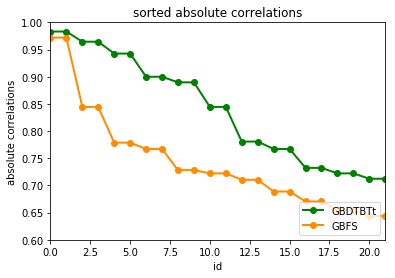

In [74]:
plt.figure()
lw = 2
plt.plot(abs_corrs_gbdt, color='g',
         lw=lw, label='GBDTBTt',marker="o")
plt.plot(abs_corrs_gbfs, color='darkorange',
         lw=lw, label='GBFS',marker="o")
plt.ylim([0.6,1])
plt.xlim([0,21])
plt.xlabel('id')
plt.ylabel('absolute correlations')
plt.title('sorted absolute correlations')
plt.legend(loc="lower right")
plt.show()
